In [ ]:
%matplotlib inline


# FBRef Pressure

This example shows how to scrape pressure events from FBRef.com and plot them as a heatmap.


In [ ]:
from urllib.request import urlopen

import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
!pip install mplsoccer
from mplsoccer import Pitch, FontManager, add_image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 162 kB 4.9 MB/s 


Scrape the data via a link to a specific table.
To get the link for a different league,
find the table you want from the website. Then click "Share & more" and copy the link from
the option "Modify & Share Table". Then "click url for sharing" and get the table as a url.



In [ ]:
URL = 'https://fbref.com/en/share/eDK2O'
df1 = pd.read_html(URL)[0]
# select a subset of the columns (Squad and pressure columns)
df1 = df1[['Unnamed: 0_level_0', 'Pressures']].copy()
df1.columns = df1.columns.droplevel()  # drop the top-level of the multi-index

In [ ]:
df2 = pd.read_excel('pressures_against.xlsx')


Index(['Squad', 'Press', 'Succ', '%', 'Def 3rd', 'Mid 3rd', 'Att 3rd'], dtype='object')

In [ ]:
# pl defensive actions - share and export - get as excel workbook 
df = pd.read_excel('pressures.xlsx')
df

,Squad,# Pl,90s,Press,Succ,%,Def 3rd,Mid 3rd,Att 3rd
0,Arsenal,21,7.0,728,252,34.6,159,333,236
1,Aston Villa,19,7.0,945,317,33.5,322,432,191
2,Bournemouth,23,7.0,1051,272,25.9,422,435,194
3,Brentford,22,7.0,912,241,26.4,280,428,204
4,Brighton,19,6.0,779,248,31.8,198,344,237
5,Chelsea,20,6.0,744,250,33.6,232,293,219
6,Crystal Palace,18,6.0,895,230,25.7,343,373,179
7,Everton,22,7.0,950,303,31.9,401,359,190
8,Fulham,23,7.0,985,294,29.8,350,416,219
9,Leeds United,20,6.0,902,302,33.5,235,419,248


Get the league average percentages



In [ ]:
pressure_cols = ['Def 3rd', 'Mid 3rd', 'Att 3rd']
df_total = pd.DataFrame(df[pressure_cols].sum())
df_total.columns = ['total']
df_total = df_total.T
df_total = df_total.divide(df_total.sum(axis=1), axis=0) * 100

Calculate the percentages for each team and sort so that the teams which press higher are last



In [ ]:
df[pressure_cols] = df[pressure_cols].divide(df[pressure_cols].sum(axis=1), axis=0) * 100.
df.sort_values(['Att 3rd', 'Def 3rd'], ascending=[True, False], inplace=True)

Get the StatsBomb logo and Fonts



In [ ]:
LOGO_URL = 'https://raw.githubusercontent.com/statsbomb/open-data/master/img/statsbomb-logo.jpg'
#sb_logo = Image.open(urlopen(LOGO_URL))

# a FontManager object for using a google font (default Robotto)
fm = FontManager()
# path effects
path_eff = [path_effects.Stroke(linewidth=3, foreground='black'),
            path_effects.Normal()]

Plot the percentages



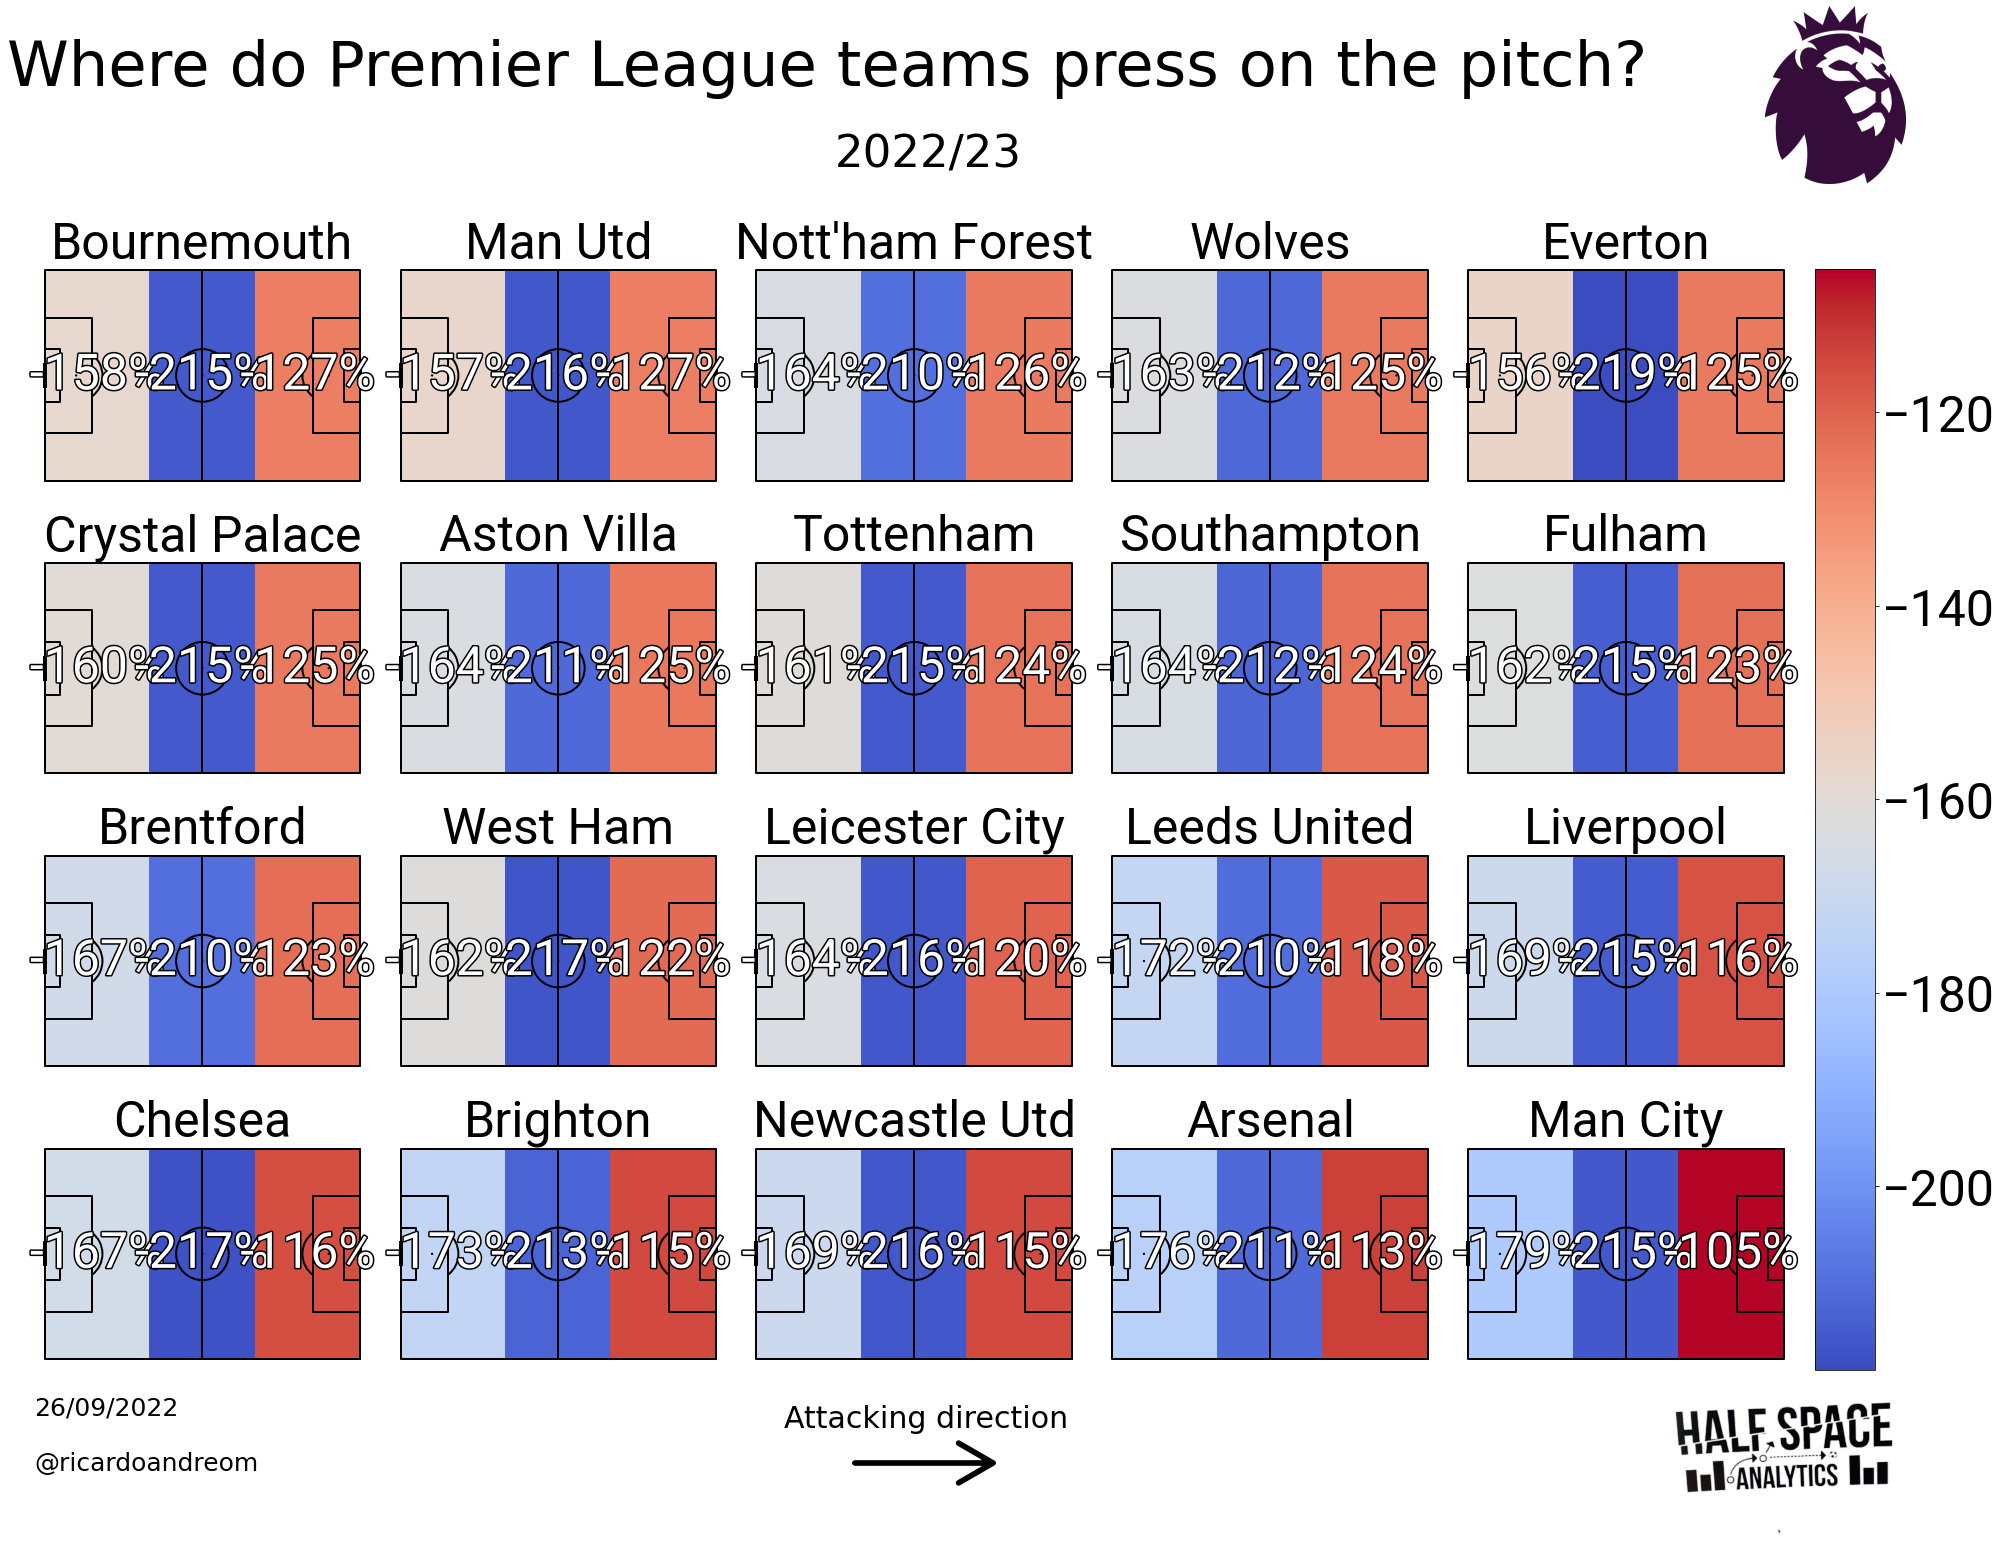

In [ ]:
# setup a mplsoccer pitch
pitch = Pitch(line_zorder=2, line_color='black', pad_top=20)

# mplsoccer calculates the binned statistics usually from raw locations, such as pressure events
# for this example we will create a binned statistic dividing
# the pitch into thirds for one point (0, 0)
# we will fill this in a loop later with each team's statistics from the dataframe
bin_statistic = pitch.bin_statistic([0], [0], statistic='count', bins=(3, 1))

GRID_HEIGHT = 0.8
CBAR_WIDTH = 0.03
fig, axs = pitch.grid(nrows=4, ncols=5, figheight=20,
                      # leaves some space on the right hand side for the colorbar
                      grid_width=0.88, left=0.025,
                      endnote_height=0.06, endnote_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      title_space=0.02, title_height=0.06, grid_height=GRID_HEIGHT)
fig.set_facecolor('white')

teams = df['Squad'].values
vmin = df[pressure_cols].min().min()  # we normalise the heatmaps with the min / max values
vmax = df[pressure_cols].max().max()
for i, ax in enumerate(axs['pitch'].flat[:len(teams)]):
    # the top of the StatsBomb pitch is zero
    # plot the title half way between zero and -20 (the top padding)
    ax.text(60, -10, teams[i],
            ha='center', va='center', fontsize=50,
            fontproperties=fm.prop)

    # fill in the bin statistics from df and plot the heatmap
    bin_statistic['statistic'] = df.loc[df.Squad == teams[i], pressure_cols].values
    heatmap = pitch.heatmap(bin_statistic, ax=ax, cmap='coolwarm', vmin=vmin, vmax=vmax)
    annotate = pitch.label_heatmap(bin_statistic, color='white', fontproperties=fm.prop,
                                   path_effects=path_eff, fontsize=50, ax=ax,
                                   str_format='{0:.0f}%', ha='center', va='center')

# if its the Bundesliga remove the two spare pitches
if len(teams) == 18:
    for ax in axs['pitch'][-1, 3:]:
        ax.remove()

# add cbar axes
cbar_bottom = axs['pitch'][-1, 0].get_position().y0
cbar_left = axs['pitch'][0, -1].get_position().x1 + 0.01
ax_cbar = fig.add_axes((cbar_left, cbar_bottom, CBAR_WIDTH,
                        # take a little bit off the height because of padding
                        GRID_HEIGHT - 0.036))
cbar = plt.colorbar(heatmap, cax=ax_cbar)
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(fm.prop)
    label.set_fontsize(50)

# title and endnote
'''add_image(sb_logo, fig,
          left=axs['endnote'].get_position().x0,
          bottom=axs['endnote'].get_position().y0,
          height=axs['endnote'].get_position().height)'''
title = axs['title'].text(0.45, 1.4, 'Where do Premier League teams press on the pitch?',
                          ha='center', va='center', fontsize=62.5)


# title and endnote
'''add_image(sb_logo, fig,
          left=axs['endnote'].get_position().x0,
          bottom=axs['endnote'].get_position().y0,
          height=axs['endnote'].get_position().height)'''


from PIL import Image
from io import BytesIO
import requests
fig.text(0.425,0.925,'2022/23',color="black",size = 45)
fig.text(0.025,0.02,'26/09/2022\n\n@ricardoandreom',color="black",size = 25)
fig.text(0.4,0.05,'Attacking direction',color="black",size = 30)
ax3 = fig.add_axes([.22,-.025,.5,.1])
ax3.axis('off')
img = Image.open('setad.png')
ax3.imshow(img)

ax4 = fig.add_axes([.6,-.04,.6,.15])
ax4.axis('off')
img1 = Image.open('halfspace_analytics.png')
ax4.imshow(img1)


ax2 = fig.add_axes([.89,.7,.07,.55])
ax2.axis('off')
img2 = Image.open('premier-league-5.png')
ax2.imshow(img2)

plt.savefig('pressures%.png',dpi=800,bbox_inches = 'tight',facecolor='white')

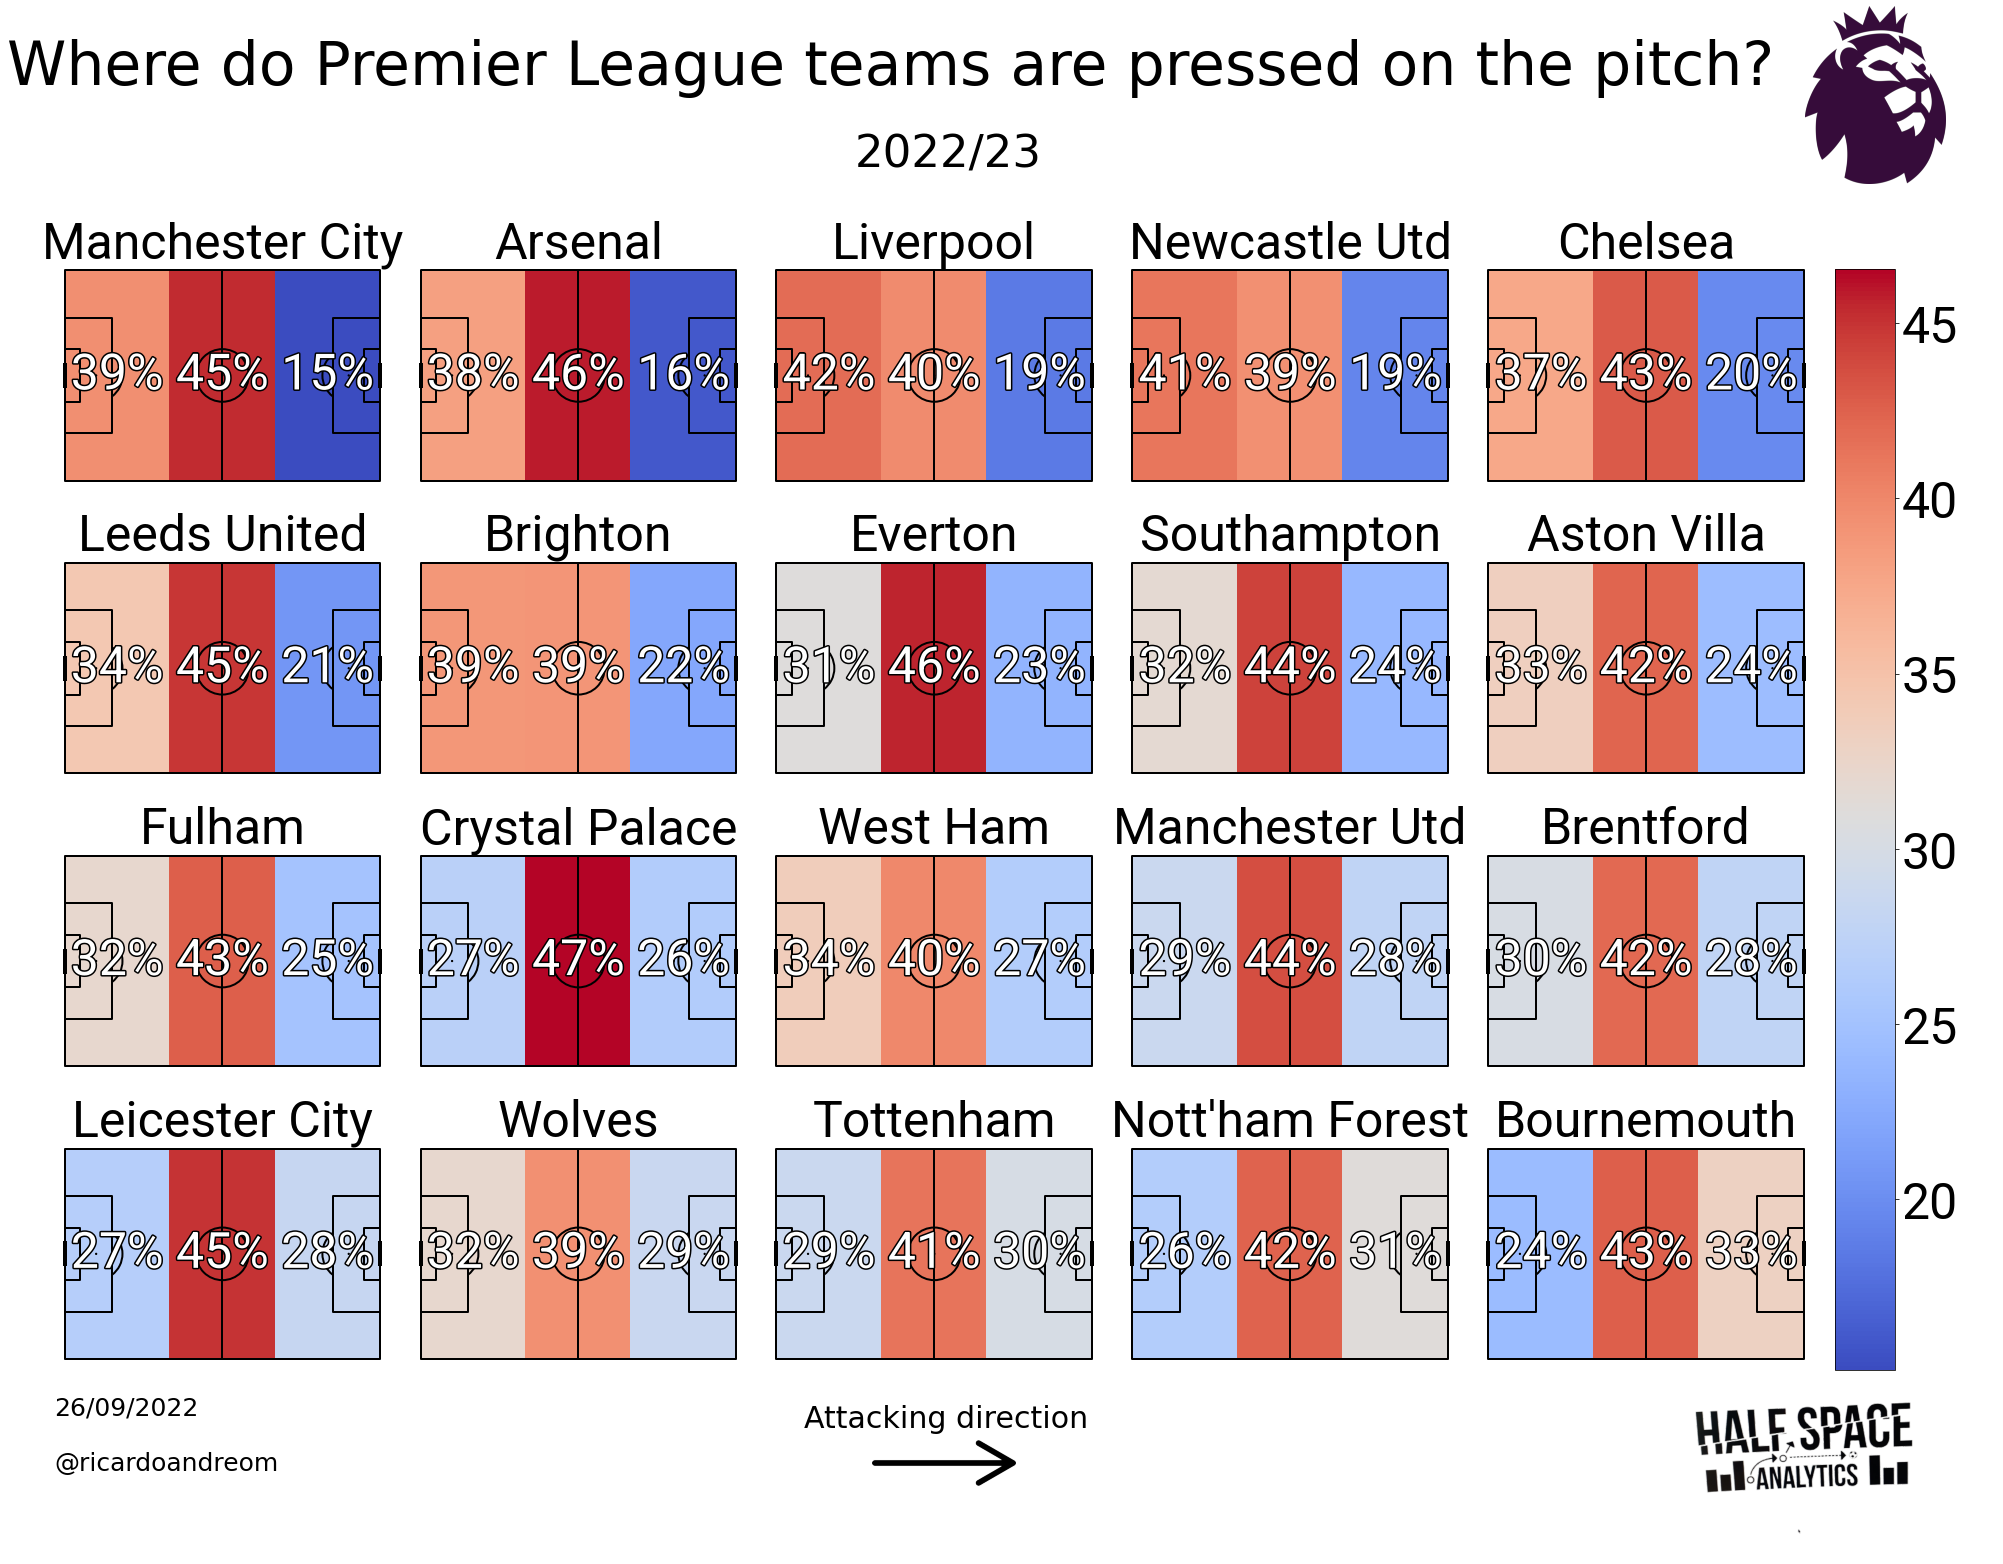

In [ ]:
#                                               AGAINST

# setup a mplsoccer pitch

pitch = Pitch(line_zorder=2, line_color='black', pad_top=20)

# mplsoccer calculates the binned statistics usually from raw locations, such as pressure events
# for this example we will create a binned statistic dividing
# the pitch into thirds for one point (0, 0)
# we will fill this in a loop later with each team's statistics from the dataframe
bin_statistic = pitch.bin_statistic([0], [0], statistic='count', bins=(3, 1))

GRID_HEIGHT = 0.8
CBAR_WIDTH = 0.03
fig, axs = pitch.grid(nrows=4, ncols=5, figheight=20,
                      # leaves some space on the right hand side for the colorbar
                      grid_width=0.88, left=0.025,
                      endnote_height=0.06, endnote_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      title_space=0.02, title_height=0.06, grid_height=GRID_HEIGHT)
fig.set_facecolor('white')

teams = df['Squad'].values
vmin = df[pressure_cols].min().min()  # we normalise the heatmaps with the min / max values
vmax = df[pressure_cols].max().max()
for i, ax in enumerate(axs['pitch'].flat[:len(teams)]):
    # the top of the StatsBomb pitch is zero
    # plot the title half way between zero and -20 (the top padding)
    ax.text(60, -10, teams[i],
            ha='center', va='center', fontsize=50,
            fontproperties=fm.prop)

    # fill in the bin statistics from df and plot the heatmap
    bin_statistic['statistic'] = df.loc[df.Squad == teams[i], pressure_cols].values
    heatmap = pitch.heatmap(bin_statistic, ax=ax, cmap='coolwarm', vmin=vmin, vmax=vmax)
    annotate = pitch.label_heatmap(bin_statistic, color='white', fontproperties=fm.prop,
                                   path_effects=path_eff, fontsize=50, ax=ax,
                                   str_format='{0:.0f}%', ha='center', va='center')

# if its the Bundesliga remove the two spare pitches
if len(teams) == 18:
    for ax in axs['pitch'][-1, 3:]:
        ax.remove()

# add cbar axes
cbar_bottom = axs['pitch'][-1, 0].get_position().y0
cbar_left = axs['pitch'][0, -1].get_position().x1 + 0.01
ax_cbar = fig.add_axes((cbar_left, cbar_bottom, CBAR_WIDTH,
                        # take a little bit off the height because of padding
                        GRID_HEIGHT - 0.036))
cbar = plt.colorbar(heatmap, cax=ax_cbar)
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(fm.prop)
    label.set_fontsize(50)

# title and endnote
'''add_image(sb_logo, fig,
          left=axs['endnote'].get_position().x0,
          bottom=axs['endnote'].get_position().y0,
          height=axs['endnote'].get_position().height)'''
title = axs['title'].text(0.475, 1.4, 'Where do Premier League teams are pressed on the pitch?',
                          ha='center', va='center', fontsize=60)


from PIL import Image
from io import BytesIO
import requests
fig.text(0.425,0.925,'2022/23',color="black",size = 45)
fig.text(0.025,0.02,'26/09/2022\n\n@ricardoandreom',color="black",size = 25)
fig.text(0.4,0.05,'Attacking direction',color="black",size = 30)
ax3 = fig.add_axes([.22,-.025,.5,.1])
ax3.axis('off')
img = Image.open('setad.png')
ax3.imshow(img)

ax4 = fig.add_axes([.6,-.04,.6,.15])
ax4.axis('off')
img1 = Image.open('halfspace_analytics.png')
ax4.imshow(img1)




ax2 = fig.add_axes([.9,.7,.07,.55])
ax2.axis('off')
img2 = Image.open('premier-league-5.png')
ax2.imshow(img2)

plt.savefig('pressures_against.png',dpi=800,bbox_inches = 'tight',facecolor='white')

Plot the percentage point difference



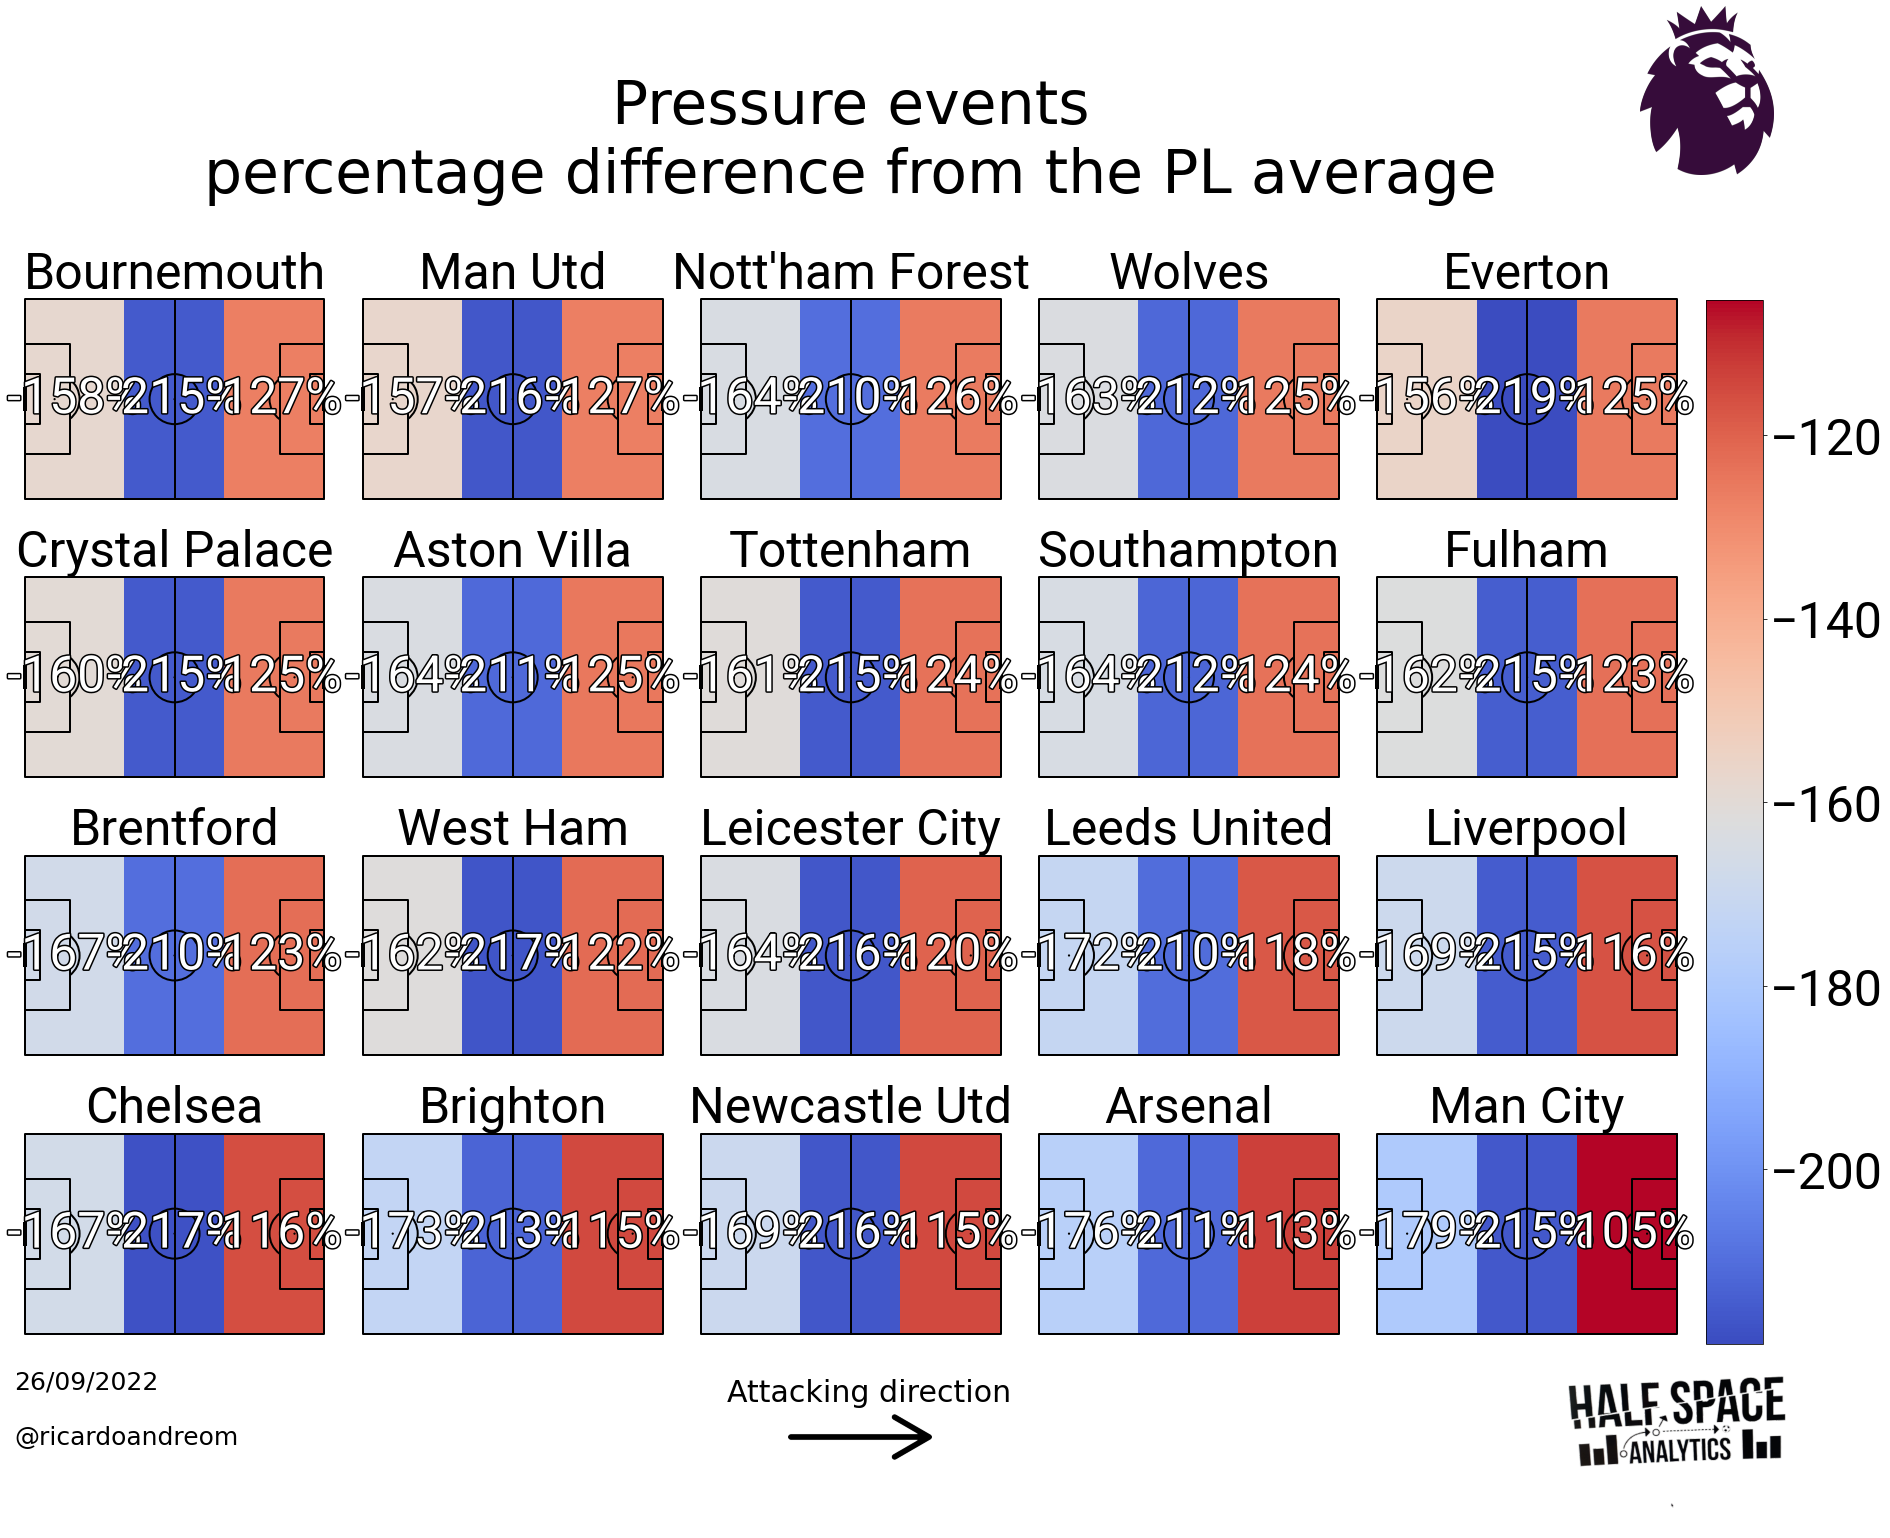

In [ ]:
# Calculate the percentage point difference from the league average
df[pressure_cols] = df[pressure_cols].values - df_total.values

GRID_HEIGHT = 0.76
fig, axs = pitch.grid(nrows=4, ncols=5, figheight=20,
                      # leaves some space on the right hand side for the colorbar
                      grid_width=0.88, left=0.025,
                      endnote_height=0.06, endnote_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      title_space=0.02, title_height=0.1, grid_height=GRID_HEIGHT)
fig.set_facecolor('white')

teams = df['Squad'].values
vmin = df[pressure_cols].min().min()  # we normalise the heatmaps with the min / max values
vmax = df[pressure_cols].max().max()

for i, ax in enumerate(axs['pitch'].flat[:len(teams)]):
    # the top of the StatsBomb pitch is zero
    # plot the title half way between zero and -20 (the top padding)
    ax.text(60, -10, teams[i], ha='center', va='center', fontsize=50, fontproperties=fm.prop)

    # fill in the bin statistics from df and plot the heatmap
    bin_statistic['statistic'] = df.loc[df.Squad == teams[i], pressure_cols].values
    heatmap = pitch.heatmap(bin_statistic, ax=ax, cmap='coolwarm', vmin=vmin, vmax=vmax)
    annotate = pitch.label_heatmap(bin_statistic, color='white', fontproperties=fm.prop,
                                   path_effects=path_eff, str_format='{0:.0f}%', fontsize=50,
                                   ax=ax, ha='center', va='center')

# if its the Bundesliga remove the two spare pitches
if len(teams) == 18:
    for ax in axs['pitch'][-1, 3:]:
        ax.remove()

# add cbar axes
cbar_bottom = axs['pitch'][-1, 0].get_position().y0
cbar_left = axs['pitch'][0, -1].get_position().x1 + 0.01
ax_cbar = fig.add_axes((cbar_left, cbar_bottom, CBAR_WIDTH,
                        # take a little bit off the height because of padding
                        GRID_HEIGHT - 0.035))
cbar = plt.colorbar(heatmap, cax=ax_cbar)
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(fm.prop)
    label.set_fontsize(50)

# title and endnote
'''add_image(sb_logo, fig,
          left=axs['endnote'].get_position().x0,
          bottom=axs['endnote'].get_position().y0,
          height=axs['endnote'].get_position().height)'''
TITLE = 'Pressure events\npercentage difference from the PL average'
title = axs['title'].text(0.5, 0.55, TITLE, ha='center', va='center', fontsize=60)

from PIL import Image
from io import BytesIO
import requests

fig.text(0.025,0.02,'26/09/2022\n\n@ricardoandreom',color="black",size = 25)
fig.text(0.4,0.05,'Attacking direction',color="black",size = 30)
ax3 = fig.add_axes([.22,-.025,.5,.1])
ax3.axis('off')
img = Image.open('setad.png')
ax3.imshow(img)

ax4 = fig.add_axes([.6,-.04,.6,.15])
ax4.axis('off')
img1 = Image.open('halfspace_analytics.png')
ax4.imshow(img1)




ax2 = fig.add_axes([.88,.7,.07,.52])
ax2.axis('off')
img2 = Image.open('premier-league-5.png')
ax2.imshow(img2)

plt.savefig('pressures_comparison.png',dpi=800,bbox_inches = 'tight',facecolor='white')
